In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
#from gatspy.periodic import LombScargleFast
from gatspy import periodic
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle
from random import randint

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcseconds
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 4096
flarecycles = 10
dayinsec=86400
background = 20
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9
# start date 59580.033829 end date + 10 years

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/

In [5]:
#magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   
magUncertainy(zeroPoints[1],20,30,20,FWHMeff[1])

0.009671857152233425

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])



In [7]:
def remove25(observations):
    global obs
    Startdate = 59580
    EndDate = Startdate + (365.25*10)
    surveyDuration = EndDate - Startdate
    print(Startdate,EndDate)
    randomstart = randint(0,75)
    exclusionStart = Startdate + (randomstart*(surveyDuration)*0.01)
    exclusionEnd = exclusionStart+(0.25*(surveyDuration))
    print(exclusionStart,exclusionEnd)
    for x in range(0,len(obs)):
        obs[x] = [y for y in obs[x] if y > exclusionEnd or y < exclusionStart]        

In [8]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [9]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency)*x)) for x in observations]
    return a

In [10]:
# def ellipsoidalFlux(observations, Frequency,exptime):
#     period = 1/(Frequency)
#     phase = [(x % (2*period)) for x in observations]
#     b = [0]*len(observations)
#     for seconds in range(0, exptime):
#         a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
#         b = map(add, a, b)
#     c = [z/exptime for z in b]
    
#     for x in range(0,len(phase)):
#         if (phase[x]+(0.5*period)) < period:
#             c[x] = c[x]*0.5
#         else:
#             c[x] = c[x]*1
#     return c
# ## this is doing something but not the right something, come back to it 

In [11]:
def ellipsoidalFlux(observations, Frequency,exptime):
    period = 1/(Frequency)
    phase = [(x % (2*period)) for x in observations]
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    
    for x in range(0,len(phase)):
        if (phase[x]+(1.5*period)) < (3*period):
            c[x] = c[x]*(1./3.)
        else:
            c[x] = c[x]*(2./3.)
    return c
## this is doing something but not the right something, come back to it 

In [12]:
def flaring(B, length, dayinsec=86400,amplitude=1):   
    global flareMag, minutes
    fouriers = np.linspace(0.00001,0.05,(dayinsec/30))
    logF = [np.log(x) for x in fouriers] # start at 30 go to a day in 30 sec increments
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers] #random.gauss(mu,sigma) to change for values from zurita
    # imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,dayinsec, (dayinsec/30)) # the day in 30 sec increments
    minutes = [x for x in seconds]
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT] # what did this even achieve? it helped with normalisation!
    normalised = [x/(np.mean(positive)) for x in positive] # find normalisation
    normalisedmin = minimum/(np.mean(positive))
    normalised = [x - normalisedmin for x in normalised]
    flareMag = [amplitude * x for x in normalised] # normalise to amplitude
    logmins = [np.log(d) for d in minutes] # for plotting?
#     plt.plot(minutes,flareMag)
#     plt.title('lightcurve')
#     plt.show()
    return flareMag

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


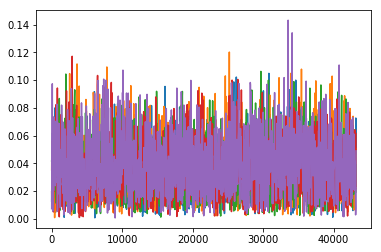

In [13]:
longflare = []
for floop in range(0,5):
    flareone = flaring(-1, flareperiod, amplitude=0.1)
    flareone = flareone[0:1440]
    positiveflare = [abs(x) for x in flareone]
    longflare.append(positiveflare)
    minutes = minutes[0:1440]
    plt.plot(minutes, longflare[floop])
plt.show()

In [14]:
def fullGraph(objectmag,frequency,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1,detail=1): # ramp controls graularity of time
    global Zmag, dayZ, Zbasic
    
#     minutesnotindays = np.linspace(0,(1051920),1051920)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
#     Minutes = [(h/(24*12)) for h in minutesnotindays] 
    
    minutesnotindays = np.linspace(0,(175320*detail),(175320*detail)+1)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
    Minutes = [(h/(24*2*detail)) for h in minutesnotindays]
    DAYS = [h + (min(obs[0])) for h in Minutes]     # 4 24 24*60
    Z = []
    #Z = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
    Z = ellipsoidalFlux(DAYS,frequency,30)
    Z = [modulationAmplitude * t for t in Z]
    Zbasic = [objectmag - t for t in Z]
    for G in range(0, len(Z)):
        #flareMinute = int(round((Z[G]*24*60*2)%(dayinsec*10*flarecycles)))
        #flareMinute = int(round(minutesnotindays[G]*60)%((dayinsec/60*2)*flarecycles)) # find array number for flaring
        flareMinute = int(round(DAYS[G]*24*60*2)%((dayinsec/(30*2))*flarecycles)) # half a day in 30 sec increments
        if flareMinute == (len(longflare)):
            flareMinute = flareMinute - 1
        Z[G] = Z[G] + longflare[flareMinute]

    Zamplitude = [t + random.gauss(0,magUncertainy(zeroPoints[4],objectmag[4],30,background,FWHMeff[4])) for t in Z] # scale amplitude and add poisson noise         
    Zmag = [objectmag - t for t in Zamplitude]
    dayZ = [t for t in DAYS]
    
    
    font = {'family' : 'serif',
        'weight' : 'normal',
    'size'   : 16}
    plt.rc('font', **font)
    plt.rc('axes',linewidth=2)
    plt.plot(dayZ,Zmag)
    plt.xlim(lower,higher)
    plt.xlabel('time')
    plt.ylabel('mag')
    plt.gca().invert_yaxis()
    plt.show()


In [15]:
# def fullGraph(objectmag,frequency,flareAmp=0.1,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1): # ramp controls graularity of time
#     global Zmag, dayZ, Zbasic
#     minutesnotindays = np.linspace(0,(1051920),1051920)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
#     Minutes = [(h/(24*12)) for h in minutesnotindays] # 4 24 24*60
#     Z = []
#     Z = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
#     Z = [modulationAmplitude * t for t in Z]
#     Zbasic = [t + objectmag for t in Z]
#     for G in range(0, len(Z)):
#         #flareMinute = int(round((Z[G]*24*60*2)%(dayinsec*10*flarecycles)))
#         flareMinute = int(round(minutesnotindays[G]*10)%((dayinsec/30)*flarecycles)) # find array number for flaring
#         if flareMinute == ((dayinsec/30)*flarecycles):
#             flareMinute = ((dayinsec/30)*flarecycles) - 1
#         Z[G] = Z[G] - longflare[flareMinute]

#     #Zamplitude = [t-random.gauss(0,magUncertainy(zeroPoints[4],objectmag[4],30,background,FWHMeff[4])) for t in Z] # scale amplitude and add poisson noise         
#     Zamplitude = [t for t in Z]
#     Zmag = [t + objectmag for t in Zamplitude]
#     dayZ = [t for t in Minutes]

#     plt.plot(dayZ,Zmag)
#     plt.xlim(lower,higher)
#     plt.xlabel('time')
#     plt.ylabel('mag')
#     plt.show()

In [16]:
def lombScargle(frequencyRange,objectmag,loopNo=1,df=0.001,fmin=0.001,numsteps=150000,modulationAmplitude=0.1,color1='darkblue',color2='mediumvioletred',color3='gold',graphmarker='o'): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = []
    totmperiod = []
    totpower = [] # reset
    SigLevel = []
    filterletter = ['o','u','g','r','i','z','y']
    colour = ['k','slateblue','mediumseagreen','red','orange','maroon','k']
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            #y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
            y[z] = ellipsoidalFlux(obs[z], frequencyRange[frange],30)
            y[z] = [modulationAmplitude * t for t in y[z]] # scaling
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/(30*2))*flarecycles)))
                y[z][G] = y[z][G] + longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs
        date = []
        amplitude = []
        mag = []
        error = []
        filts = []
        for z in range(1, len(y)):
            #date.extend([x for x in obs[z]])
            date.extend(obs[z])
            amplitude = [t + random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            plotmag = [objectmag[z] - t for t in amplitude]
            mag.extend([objectmag[z] - t for t in amplitude]) # add actual mag
            error.extend([sigSys + magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])]*len(amplitude))
            ploterror = [sigSys + magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])]*len(amplitude)
            filts.extend([filterletter[z]]*len(amplitude))
            plt.errorbar(obs[z],plotmag,yerr=[ploterror,ploterror],zorder=10,fmt=graphmarker,color=colour[z])


#         plt.plot(date, mag, 'o')
#         #plt.xlim(lower,higher)
#         plt.xlabel('time (days)')
#         plt.ylabel('mag')
#         plt.gca().invert_yaxis()
#         plt.show()

        #curve and observations
        plt.plot(dayZ[0],Zmag[0][0],color=color1,label='Full Simulated Lightcurve')
        plt.plot(date[0],mag[0],graphmarker, color=color3,label='Observations')
        plt.plot(dayZ[0],Zbasic[0][0],color=color2,label='Ellipsoidal Modulation')
        plt.plot(dayZ,Zmag,color=color1)
        plt.plot(dayZ,Zbasic,color=color2)
        #plt.errorbar(date, mag, yerr=[error,error],zorder=10, fmt=graphmarker,color=color3)
        plt.xlim((date[15]-10),(date[15]+20))#(59669.4,59674.4)
        plt.xlabel('Time (MJD)')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
        plt.savefig('observations.png',dpi=1000,bbox_inches='tight')
        plt.show()
                     

#         model = periodic.LombScargleMultibandFast(fit_period=False)
#         model.fit(date, mag, error, filts)
#         power = model.score_frequency_grid(fmin, df, numsteps) 
        
#         if 1/(frequencyRange[frange]) > 0.51:
#             model.optimizer.period_range=(0.5, 10)
#         elif 1/(frequencyRange[frange]) > 0.011:
#             model.optimizer.period_range=(0.01, 0.52)
#         else:
#             model.optimizer.period_range=(0.003, 0.012)
#         #model.optimizer.period_range=(0.003, 100)
#         LSperiod = model.best_period

#         fig, ax = plt.subplots()
#         ax.plot(1./freqs, power,color=color1)
#         ax.set(xlim=(0, 10), ylim=(0, 1.2),
#                xlabel='Period (days)',
#                ylabel='Lomb-Scargle Power');
#         plt.show()

#         period = 1/(frequencyRange[frange])
#         phase = [(day % (period*2))/(period*2) for day in date]
#         idealphase = [(day % (period*2))/(period*2) for day in dayZ]
#         print(len(phase),len(idealphase))
#         plt.plot(idealphase[0],Zmag[0][0],'o',color=color1,label='Full Simulated Lightcurve')
#         plt.plot(phase[0],mag[0],graphmarker,color=color3, label='Observations')
#         plt.plot(idealphase[0],Zbasic[0][0],'o',color=color2,label='Ellipsoidal Modulation')
        
#         plt.plot(idealphase,Zmag,'o',color=color1)
#         plt.plot(phase, mag, graphmarker,color=color3)
#         plt.plot(idealphase,Zbasic,'o',color=color2)
#         plt.xlabel('Phase')
#         plt.ylabel('Magnitude')
#         plt.gca().invert_yaxis()
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.show()

        #print('actualperiod', period, 'measured period', np.mean(LSperiod),power.max())# 'power',np.mean(power[maxpos]))
        #print(frequencyRange[frange], 'z', z)

        #totperiod.append(1/(frequencyRange[frange]))
        #totmperiod.append(np.mean(LSperiod))
        #totpower.append(power.max())

#         measuredpower.append(power.max())
#         maxpower = []           
#         counter = 0.
#         for loop in range(0,loopNo):
#             random.shuffle(date)
#             model = periodic.LombScargleMultibandFast(fit_period=False)
#             model.fit(date, mag, error, filts)
#             power = model.score_frequency_grid(fmin, df, numsteps)  
#             maxpower.append(power.max())


#         for X in range(0, len(maxpower)):
#             if maxpower[X] > measuredpower[-1]:
#                 counter = counter + 1. 
#         Significance = (1.-(counter/len(maxpower)))
#         # print('sig', Significance, 'counter', counter)
#         SigLevel.append(Significance)


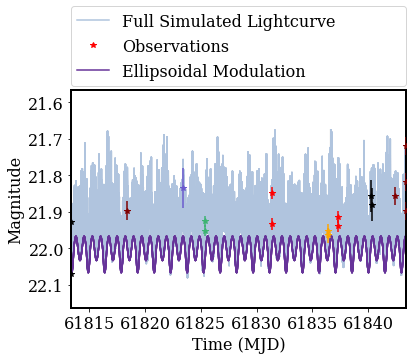

In [77]:
lombScargle([FrangeLoop[10]],([MagRange[10]]*7),loopNo=1,color3='red',color1='lightsteelblue',color2='rebeccapurple',graphmarker='*')

In [17]:
findObservations([(630,)])
remove25(obs)
averageFlux(obs[0], 1, 30)
longflare = []
for floop in range(0,flarecycles):
    flareone = flaring(-1, flareperiod, amplitude=0.25)
    flareone = flareone[0:1440]
    positiveflare = [abs(x) for x in flareone]
    longflare.extend(positiveflare)
    


(59580, 63232.5)
(60383.55, 61296.675)


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [17]:
findObservations([(630,)])

In [18]:
print(obs)

[[59669.401036000003, 59669.415071000003, 59675.397819999998, 59677.415775000001, 59680.223431999999, 59680.237016999999, 59680.393256000003, 59683.295665999998, 59683.321671999998, 59683.323508000001, 59685.190992000003, 59685.194561999997, 59685.205355999999, 59685.296957999999, 59686.300793000002, 59686.318339999998, 59686.330581000002, 59686.345019, 59688.417806999998, 59691.311783999998, 59691.326623000001, 59697.201801000003, 59697.226375999999, 59704.123689, 59704.137447000001, 59713.211079000001, 59718.200410999998, 59718.224856000001, 59718.230648999997, 59718.252210999999, 59718.358633999997, 59718.37169, 59718.395214999997, 59718.407872000003, 59729.068837999999, 59729.093142999998, 59751.027583000003, 59751.049007000001, 59757.138006000001, 59769.953996999997, 59769.9594, 59769.965235000003, 59769.971061999997, 59777.082416999998, 59777.102072000001, 59786.070033999997, 59786.090433999998, 59786.097306000003, 59786.109027999999, 59791.009824000001, 59801.005361000003, 59801

In [18]:
print(np.mean(longflare), np.std(longflare))

(0.086759644175273029, 0.047309105406924429)


In [19]:
lower=(min(obs[0]))
higher=(min(obs[0])+10)
print(lower,higher)
print(len(obs))

(59669.401036000003, 59679.401036000003)
7


In [20]:
# fullGraph([20.]*7,1.1,lower=(min(obs[0])),higher=(min(obs[0])+10),ramp=10,detail=3)
# lombScargle([1.1],([20.]*7),loopNo=1)
#  # 40 background corresponing to R band at new moon, could be made more detailed?

In [20]:
#PrangeLoop = [(10./(60.*24.)),(20./(60.*24.)),(30./(60.*24.)),(40./(60.*24.)),(50./(60.*24.)),(60./(60.*24.)),(120./(60.*24.)),(180./(60.*24.)),(240./(60.*24.)),(300./(60.*24.)),(360./(60.*24.)),(0.5),(0.75),(1.),(2.),(3.),(4.),(5.),(10.),(20.),(30.),(50.),(100.)]
PrangeLoop = np.logspace(-2.5,2,20)
FrangeLoop = [(1/x) for x in PrangeLoop]
MagRange = np.linspace(17,24,15)


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.5 to 10
 - Computing periods at 32820 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


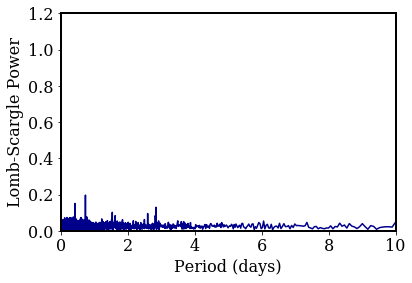

(694, 525961)


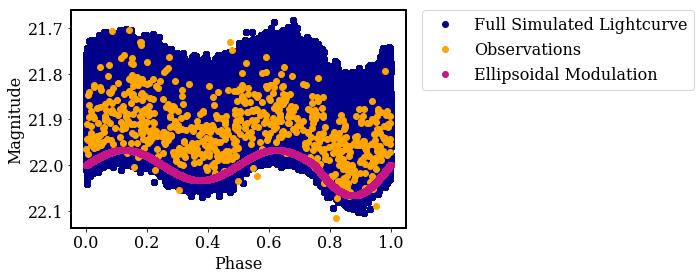

('actualperiod', 0.73861998220793579, 'measured period', 0.73861635895663935, 0.19686732432889159)
(1.3538761800225447, 'z', 6)


In [18]:
fullGraph([MagRange[10]]*7,FrangeLoop[10],lower=(min(obs[0])),higher=(min(obs[0])+10),ramp=10,detail=3)
lombScargle([FrangeLoop[10]],([MagRange[10]]*7),loopNo=1,color3='orange')

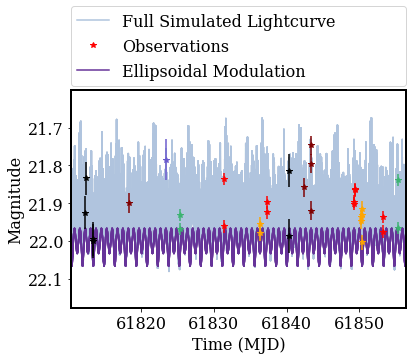

In [75]:
#fullGraph([MagRange[10]]*7,FrangeLoop[10],lower=(min(obs[0])),higher=(min(obs[0])+10),ramp=10,detail=4.5)
lombScargle([FrangeLoop[10]],([MagRange[10]]*7),loopNo=1,color3='red',color1='lightsteelblue',color2='rebeccapurple',graphmarker='*')

In [114]:
print((error))

[0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.0098527249507959231, 0.00985272

fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []

MagRange = np.linspace(17,24,15)
#MagRange = [17,18,19,20,21,22,23,24]
for h in range(0,len(MagRange)):
    lombScargle(FrangeLoop,([MagRange[h]]*7),loopNo=100)
    fullmeasuredPeriod.append(totmperiod)
    fullPeriod.append(totperiod)
    fullPower.append(totpower)
    fullSigLevel.append(SigLevel)
    fullMag.append([MagRange[h]]*len(FrangeLoop))



In [ ]:
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []

MagRange = np.linspace(17,24,15)
#MagRange = [17,18,19,20,21,22,23,24]
for h in range(0,len(MagRange)):
    lombScargle(FrangeLoop,([MagRange[h]]*7),loopNo=100)
    fullmeasuredPeriod.append(totmperiod)
    fullPeriod.append(totperiod)
    fullPower.append(totpower)
    fullSigLevel.append(SigLevel)
    fullMag.append([MagRange[h]]*len(FrangeLoop))



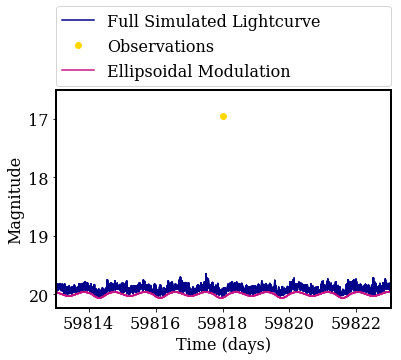

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.003 to 0.012
 - Computing periods at 4318246 steps


In [ ]:
lombScargle([FrangeLoop[0]],([MagRange[0]]*7),loopNo=100)

In [ ]:
print(SigLevel)
print(totmperiod)
print(totperiod)
#print(FrangeLoop[-1])

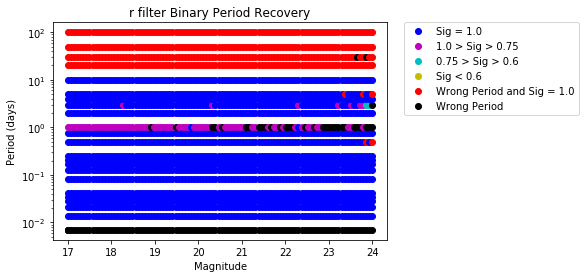

In [50]:
FilterLabel = ['u','g','r','i','z','y']

for x in range(2,3):#(0,len(fullSigLevel)):
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'bo',label='Sig = 1.0')
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'mo',label='1.0 > Sig > 0.75')
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'co',label='0.75 > Sig > 0.6')
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'yo',label='Sig < 0.6')
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'ro',label='Wrong Period and Sig = 1.0')
    plt.plot(fullMag[0][0][0],fullPeriod[2][0][0],'ko',label='Wrong Period')
    for y in range(0,len(MagRange)):
        for z in range(0,len(FrangeLoop)):
            Label = 0

            if fullmeasuredPeriod[x][y][z] < (fullPeriod[x][y][z]+(fullPeriod[x][y][z]*0.1)) and fullmeasuredPeriod[x][y][z] > (fullPeriod[x][y][z]-(fullPeriod[x][y][z]*0.1)):
                if fullSigLevel[x][y][z] == 1.:
                    colour = 'bo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 1. and fullSigLevel[x][y][z] > 0.75:
                    colour = 'mo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 0.75 and fullSigLevel[x][y][z] > 0.6:
                    colour = 'co'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                elif fullSigLevel[x][y][z] < 0.6:
                    colour = 'yo'
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
                    
            else:
                if fullSigLevel[x][y][z] == 1.:
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],'ro')
                else: 
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],'ko')
    plt.xlabel('Magnitude')
    plt.ylabel('Period (days)')
    plt.yscale('log')
    plt.title(FilterLabel[x]+' filter Binary Period Recovery')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [95]:
for y in range(0,len(MagRange)):
    for z in range(0, len(FrangeLoop)):
        if fullmeasuredPeriod[y][z] < (fullPeriod[y][z]+(fullPeriod[y][z]*0.05)) and fullmeasuredPeriod[y][z] > (fullPeriod[y][z]-(fullPeriod[y][z]*0.05)):
            donothing = 0 
        else: 
            fullSigLevel[y][z] = 0


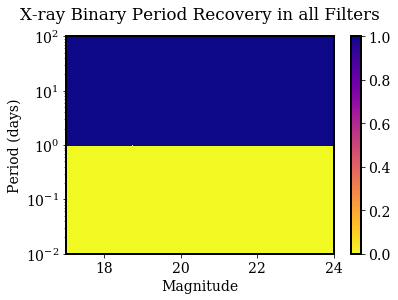

In [96]:
FilterLabel = ['u','g','r','i','z','y']


im = plt.pcolor(fullMag,fullPeriod,fullSigLevel,cmap='plasma_r',vmin=0,vmax=1)
plt.yscale('log')
plt.colorbar(im)
font = {'family' : 'serif',
        'weight' : 'normal',
    'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=2)
plt.xlabel('Magnitude')#,fontweight='semibold')
plt.ylabel('Period (days)')#,fontweight='semibold')
plt.title('X-ray Binary Period Recovery in all Filters',y=1.05)#,fontweight='semibold')
plt.show()


# im = plt.pcolor(fullMag,fullPeriod,fullPeriodDifference,cmap='plasma')
# plt.yscale('log')
# plt.colorbar(im)
# #plt.xlim(14,25)
# #plt.rc('axes',linewidth=3,weight='bold')#,'size', 22)
# plt.xlabel('Magnitude')#,fontweight='semibold')
# plt.ylabel('Period (days)')#,fontweight='semibold')
# plt.title('X-ray Binary Period Recovery in all Filters',y=1.05)#,fontweight='semibold')
# plt.show()

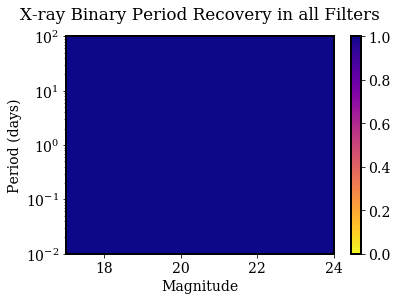

In [94]:
FilterLabel = ['u','g','r','i','z','y']


im = plt.pcolor(fullMag,fullPeriod,fullSigLevel,cmap='plasma_r',vmin=0,vmax=1)
plt.yscale('log')
plt.colorbar(im)
font = {'family' : 'serif',
        'weight' : 'normal',
    'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=2)
plt.xlabel('Magnitude')#,fontweight='semibold')
plt.ylabel('Period (days)')#,fontweight='semibold')
plt.title('X-ray Binary Period Recovery in all Filters',y=1.05)#,fontweight='semibold')
plt.show()


# im = plt.pcolor(fullMag,fullPeriod,fullPeriodDifference,cmap='plasma')
# plt.yscale('log')
# plt.colorbar(im)
# #plt.xlim(14,25)
# #plt.rc('axes',linewidth=3,weight='bold')#,'size', 22)
# plt.xlabel('Magnitude')#,fontweight='semibold')
# plt.ylabel('Period (days)')#,fontweight='semibold')
# plt.title('X-ray Binary Period Recovery in all Filters',y=1.05)#,fontweight='semibold')
# plt.show()

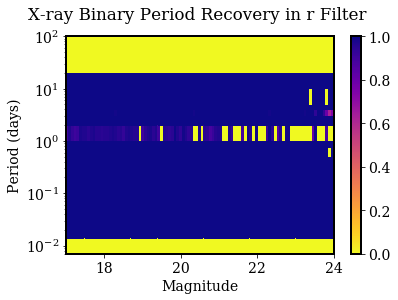

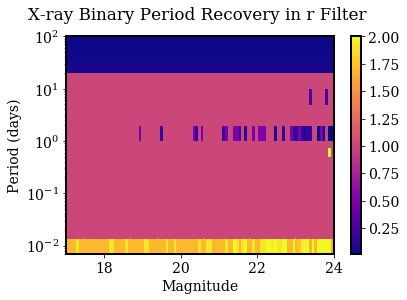

In [174]:
FilterLabel = ['u','g','r','i','z','y']

for x in range(2,3):#(0,len(fullSigLevel)):
    im = plt.pcolor(fullMag[x],fullPeriod[x],fullSigLevel[x],cmap='plasma_r',vmin=0,vmax=1)
    plt.yscale('log')
    plt.colorbar(im)
    font = {'family' : 'serif',
            'weight' : 'normal',
        'size'   : 14}
    plt.rc('font', **font)
    plt.rc('axes',linewidth=2)
    plt.xlabel('Magnitude')#,fontweight='semibold')
    plt.ylabel('Period (days)')#,fontweight='semibold')
    plt.title('X-ray Binary Period Recovery in '+FilterLabel[x]+' Filter ',y=1.05)#,fontweight='semibold')
    plt.show()
    
for x in range(2,3):#(0,len(fullSigLevel)):
    im = plt.pcolor(fullMag[x],fullPeriod[x],fullPeriodDifference[x],cmap='plasma')
    plt.yscale('log')
    plt.colorbar(im)
    #plt.xlim(14,25)
    #plt.rc('axes',linewidth=3,weight='bold')#,'size', 22)
    plt.xlabel('Magnitude')#,fontweight='semibold')
    plt.ylabel('Period (days)')#,fontweight='semibold')
    plt.title('X-ray Binary Period Recovery in '+FilterLabel[x]+' Filter ',y=1.05)#,fontweight='semibold')
    plt.show()

In [109]:
#print(fullSigLevel[2])
#print(fullmeasuredPeriod[2])
#print(fullMag[0][0][0])
print(fullmeasuredPeriod[2][0][-5:-1])
print(fullPeriod[2][0][-5:-1])

[10.001064464349943, 0.94989103909706951, 0.96515658009547767, 1.0175237061845677]
[10.0, 20.0, 30.0, 50.0]


In [141]:
for x in range(0,len(fullSigLevel)):
    for y in range(0,len(MagRange)):
        plt.scatter(fullMag[x][y],fullPeriod[x][y],c=fullSigLevel[x][y])
for x in range(0,len(fullSigLevel)):
    for y in range(0,len(MagRange)):
        for y in range(0,len(FrangeLoop)):
            if fullmeasuredPeriod[x][y][z] > (fullPeriod[x][y][z]+(fullPeriod[x][y][z]*0.1)) or fullmeasuredPeriod[x][y][z] < (fullPeriod[x][y][z]-(fullPeriod[x][y][z]*0.1)):
                plt.scatter(fullMag[x][y][z],fullPeriod[x][y][z],'ro',label='Wrong Period')
        
                        
    plt.xlabel('Magnitude')
    plt.ylabel('Period (days)')
    plt.yscale('log')
    plt.title('R filter Binary Period Recovery')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [125]:
fullPeriod

[[[0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0]],
 [[0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944444444444444, 0.041666666666666664, 0.25, 1.0, 5.0, 10.0, 50.0],
  [0.006944